# Advent of Code 2018

In [1]:
import os
import re
import string

from collections import Counter, defaultdict, deque
from datetime import datetime
from itertools import accumulate, chain, combinations, cycle, zip_longest
import operator as op

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import requests

from scipy.spatial.distance import cdist
from scipy.signal import convolve2d
from scipy.ndimage import convolve

%load_ext blackcellmagic
%matplotlib inline

In [2]:
def input_for_day(day):
    file_name = f"day{day:0>2}_input"
    if os.path.exists(file_name):
        return os.path.abspath(file_name)
    with open("session", "r") as session_file:
        response = requests.get(
            f"https://adventofcode.com/2018/day/{day}/input",
            cookies={"session": session_file.read()},
        )
    with open(file_name, "w") as input_file:
        print(response.text.strip(), file=input_file)
    return os.path.abspath(file_name)

## Day 1
### Part One
Starting with a frequency of zero, what is the resulting frequency after all of the changes in frequency have been applied?

In [3]:
%%time
with open(input_for_day(1), "r") as input_file:
    print(f"Answer: {sum(map(int, input_file))}")

Answer: 538
CPU times: user 2.36 ms, sys: 659 µs, total: 3.02 ms
Wall time: 239 ms


### Part Two
What is the first frequency your device reaches twice?

In [4]:
%%time
freq_set = {0}
with open(input_for_day(1), "r") as input_file:
    for freq in accumulate(cycle(int(line) for line in input_file)):
        if freq in freq_set or freq_set.add(freq):
            print(f"Answer: {freq}")
            break

Answer: 77271
CPU times: user 40.2 ms, sys: 0 ns, total: 40.2 ms
Wall time: 61.9 ms


## Day 2
### Part One
What is the checksum for your list of box IDs?

In [5]:
%%time
with open(input_for_day(2), "r") as input_file:
    counters = [Counter(n.strip()).values() for n in input_file]
checksum = sum(2 in c for c in counters) * sum(3 in c for c in counters)
print(f"Answer: {checksum}")

Answer: 5976
CPU times: user 7.96 ms, sys: 0 ns, total: 7.96 ms
Wall time: 193 ms


### Part Two
What letters are common between the two correct box IDs?

In [6]:
%%time
with open(input_for_day(2), "r") as input_file:
    counters = {x: Counter(x).values() for x in (n.strip() for n in input_file)}
for x, y in combinations(
    (n for n, c in counters.items() if any(s in c for s in (2, 3))), 2
):
    if sum(a != b for a, b in zip(x, y)) == 1:
        print(f"Answer: {''.join(a for a, b in zip(x, y) if a == b)}")
        break

Answer: xretqmmonskvzupalfiwhcfdb
CPU times: user 14.8 ms, sys: 5.82 ms, total: 20.6 ms
Wall time: 43.7 ms


## Day 3
### Part One
How many square inches of fabric are within two or more claims?

In [7]:
%%time
expr = re.compile(r"#(\d+)\s@\s(\d+),(\d+):\s(\d+)x(\d+)")
fabric = np.zeros((1000, 1000), dtype=np.uint32)
with open(input_for_day(3), "r") as input_file:
    for claim in input_file:
        _, x, y, w, h = map(int, expr.match(claim).groups())
        fabric[y : y + h, x : x + w] += 1
    print(f"Answer: {np.sum(fabric > 1)}")

Answer: 117948
CPU times: user 26.1 ms, sys: 1.64 ms, total: 27.7 ms
Wall time: 262 ms


### Part Two
What is the ID of the only claim that doesn't overlap?

In [8]:
%%time
expr = re.compile(r"#(\d+)\s@\s(\d+),(\d+):\s(\d+)x(\d+)")
fabric = np.zeros((1000, 1000), dtype=np.uint32)
with open(input_for_day(3), "r") as input_file:
    claims = [list(map(int, expr.match(claim).groups())) for claim in input_file]
for claim in claims:
    _, x, y, w, h = claim
    fabric[y : y + h, x : x + w] += 1
for claim in claims:
    claim_id, x, y, w, h = claim
    if np.all(fabric[y : y + h, x : x + w] == 1):
        print(f"Answer: {claim_id}")
        break

Answer: 567
CPU times: user 16.2 ms, sys: 9.02 ms, total: 25.3 ms
Wall time: 63 ms


## Day 4
### Part One
What is the ID of the guard you chose multiplied by the minute you chose?

In [9]:
%%time
entry_expr = re.compile(r"\[(.+)\]\s(.*)")
guard_expr = re.compile("Guard\s#(\d+)")

guards = defaultdict(Counter)
with open(input_for_day(4), "r") as input_file:
    lines = (entry_expr.match(entry).groups() for entry in sorted(input_file))
for timestamp, event in ((datetime.strptime(t, "%Y-%m-%d %H:%M"), e) for t, e in lines):
    if event.startswith("Guard"):
        guard = int(guard_expr.match(event).group(1))
    elif event.startswith("falls"):
        start = timestamp
    elif event.startswith("wakes"):
        duration = int((timestamp - start).total_seconds()) // 60
        guards[guard].update(Counter(start.minute + i for i in range(duration)))

_, guard = max((sum(c.values()), g) for g, c in guards.items())

print(f"Answer: {guard * guards[guard].most_common()[0][0]}")

Answer: 4716
CPU times: user 22.5 ms, sys: 7.96 ms, total: 30.5 ms
Wall time: 85.9 ms


### Part Two
What is the ID of the guard you chose multiplied by the minute you chose? 

In [10]:
%%time
entry_expr = re.compile(r"\[(.+)\]\s(.*)")
guard_expr = re.compile("Guard\s#(\d+)")

guards = defaultdict(Counter)
with open(input_for_day(4), "r") as input_file:
    lines = (entry_expr.match(entry).groups() for entry in sorted(input_file))
for timestamp, event in ((datetime.strptime(t, "%Y-%m-%d %H:%M"), e) for t, e in lines):
    if event.startswith("Guard"):
        guard = int(guard_expr.match(event).group(1))
    elif event.startswith("falls"):
        start = timestamp
    elif event.startswith("wakes"):
        duration = int((timestamp - start).total_seconds()) // 60
        guards[guard].update(Counter(start.minute + i for i in range(duration)))

(_, minute), guard = max((c.most_common()[0][::-1], g) for g, c in guards.items())

print(f"Answer: {guard * minute}")

Answer: 117061
CPU times: user 31 ms, sys: 173 µs, total: 31.1 ms
Wall time: 64.6 ms


## Day 5
### Part One
How many units remain after fully reacting the polymer you scanned?

In [11]:
%%time
def collapse(s):
    p = ["_"]
    for u in s:
        v = p[-1]
        p.pop() if v != u and v.lower() == u.lower() else p.append(u)

    return len(p) - 1


with open(input_for_day(5), "r") as input_file:
    print(f"Answer: {collapse(input_file.read().strip())}")

Answer: 11252
CPU times: user 22.5 ms, sys: 0 ns, total: 22.5 ms
Wall time: 195 ms


### Part Two
What is the length of the shortest polymer you can produce by removing all units of exactly one type and fully reacting the result?

In [12]:
%%time
def collapse(s):
    p = ["_"]
    for u in s:
        v = p[-1]
        p.pop() if v != u and v.lower() == u.lower() else p.append(u)

    return len(p) - 1


with open(input_for_day(5), "r") as input_file:
    data = input_file.read().strip()
min_length = min(
    collapse(s)
    for s in (
        data.replace(l, "").replace(l.swapcase(), "") for l in string.ascii_lowercase
    )
)
print(f"Answer: {min_length}")

Answer: 6118
CPU times: user 568 ms, sys: 8.25 ms, total: 576 ms
Wall time: 597 ms


## Day 6
### Part One
What is the size of the largest area that isn't infinite?

In [13]:
%%time
with open(input_for_day(6), "r") as input_file:
    points = np.fromiter(
        chain.from_iterable(map(int, l.strip().split(",")) for l in input_file), np.uint
    ).reshape(50, 2)

# Boundaries
tl = np.min(points, axis=0)
br = np.max(points, axis=0) + 1

# Index grid
xx, yy = np.mgrid[tl[0] : br[0], tl[1] : br[1]]
positions = np.vstack([xx.ravel(), yy.ravel()]).T

# Manhatten distances
dists = cdist(positions, points, metric="cityblock")
min_dists = np.min(dists, axis=1)

# Mapping to pointts
index_array = min_dists[..., np.newaxis] == dists

# Non ambigious distances
non_ambigious_index = np.sum(index_array, axis=1) == 1
index_array = index_array[non_ambigious_index]

# Borders to filter infinit regions
border_index = np.any(np.vstack([tl, br - 1])[:, np.newaxis] == positions, axis=(0, 2))
border_index = border_index[non_ambigious_index]
border_index = np.any(index_array[border_index], axis=0)

# Compute arrea for all points
area = np.sum(index_array, axis=0)

# Remove points that areas touch the borders
area[border_index] = -1

print(f"Answer: {np.max(area)}")

Answer: 4754
CPU times: user 171 ms, sys: 31.9 ms, total: 203 ms
Wall time: 350 ms


### Part Two
What is the size of the region containing all locations which have a total distance to all given coordinates of less than 10000?

In [14]:
%%time
with open(input_for_day(6), "r") as input_file:
    points = np.fromiter(
        chain.from_iterable(map(int, l.strip().split(",")) for l in input_file), np.uint
    ).reshape(50, 2)

# Boundaries
tl = np.min(points, axis=0)
br = np.max(points, axis=0) + 1

# Index grid
xx, yy = np.mgrid[tl[0] : br[0], tl[1] : br[1]]
positions = np.vstack([xx.ravel(), yy.ravel()]).T

# Manhatten distances
dists = cdist(positions, points, metric="cityblock")

print(f"Answer: {np.sum(np.sum(dists, axis=1) < 10000)}")

Answer: 42344
CPU times: user 35.1 ms, sys: 0 ns, total: 35.1 ms
Wall time: 67.1 ms


## Day 7
### Part One
In what order should the steps in your instructions be completed?

In [15]:
%%time
G = nx.DiGraph()
with open(input_for_day(7), "r") as input_file:
    G.add_edges_from(re.findall("\s(\w)\s", edge) for edge in input_file)

result = []
while G.nodes:
    result.append(min(G.in_degree(G.nodes), key=lambda x: (x[1], x[0]))[0])
    G.remove_node(result[-1])

print(f"Answer: {''.join(result)}")

Answer: JNOIKSYABEQRUVWXGTZFDMHLPC
CPU times: user 4.41 ms, sys: 0 ns, total: 4.41 ms
Wall time: 165 ms


### Part Two
With 5 workers and the 60+ second step durations described above, how long will it take to complete all of the steps?

In [16]:
%%time
G = nx.DiGraph()
with open(input_for_day(7), "r") as input_file:
    G.add_edges_from(re.findall("\s(\w)\s", edge) for edge in input_file)

tick = 0
time_left = Counter({n: ord(n) - 4 for n in G.nodes})
while G.nodes:
    ready_nodes = [
        x[0]
        for x in sorted(G.in_degree(G.nodes), key=lambda x: (x[1], x[0]))
        if x[1] == 0
    ]
    nodes_changed = False
    while not nodes_changed:
        tick = tick + 1
        for node in ready_nodes[:5]:
            time_left.subtract(node)
            if time_left[node] == 0:
                G.remove_node(node)
                nodes_changed = True

print(f"Answer: {tick}")

Answer: 1099
CPU times: user 10.4 ms, sys: 0 ns, total: 10.4 ms
Wall time: 39.1 ms


## Day 8
### Part One
What is the sum of all metadata entries?

In [17]:
%%time
def sum_meta(tree):
    child_count = next(tree)
    metadata_count = next(tree)
    return sum(sum_meta(tree) for _ in range(child_count)) + sum(
        next(tree) for _ in range(metadata_count)
    )


with open(input_for_day(8), "r") as input_file:
    print(f"Answer: {sum_meta(map(int, input_file.read().split()))}")

Answer: 42798
CPU times: user 12.6 ms, sys: 445 µs, total: 13 ms
Wall time: 117 ms


### Part Two
What is the value of the root node?

In [18]:
%%time
def sum_childs(tree):
    child_count = next(tree)
    metadata_count = next(tree)
    child_values = [sum_childs(tree) for _ in range(child_count)]
    metadata_values = (next(tree) for _ in range(metadata_count))
    return (
        sum(child_values[i - 1] for i in metadata_values if 0 < i <= child_count)
        if child_count
        else sum(metadata_values)
    )


with open(input_for_day(8), "r") as input_file:
    print(f"Answer: {sum_childs(map(int, input_file.read().split()))}")

Answer: 23798
CPU times: user 12.5 ms, sys: 275 µs, total: 12.8 ms
Wall time: 40.6 ms


## Day 9
### Part One
What is the winning Elf's score?

In [19]:
%%time
with open(input_for_day(9), "r") as input_file:
    players, marbles = map(int, re.findall(r"\d+", input_file.read()))

marble_circle = deque([0])
scores = Counter({i: 0 for i in range(players)})
for current_count in range(1, marbles + 1):
    if current_count % 23 == 0:
        marble_circle.rotate(7)
        scores[current_count % players] += current_count + marble_circle.pop()
        marble_circle.rotate(-1)
    else:
        marble_circle.rotate(-1)
        marble_circle.append(current_count)

print(f"Answer: {max(scores.values())}")

Answer: 404502
CPU times: user 34.7 ms, sys: 0 ns, total: 34.7 ms
Wall time: 74.4 ms


### Part Two
What would the new winning Elf's score be if the number of the last marble were 100 times larger?

In [20]:
%%time
with open(input_for_day(9), "r") as input_file:
    players, marbles = map(int, re.findall(r"\d+", input_file.read()))
marbles *= 100

marble_circle = deque([0])
scores = Counter({i: 0 for i in range(players)})
for current_count in range(1, marbles + 1):
    if current_count % 23 == 0:
        marble_circle.rotate(7)
        scores[current_count % players] += current_count + marble_circle.pop()
        marble_circle.rotate(-1)
    else:
        marble_circle.rotate(-1)
        marble_circle.append(current_count)

print(f"Answer: {max(scores.values())}")

Answer: 3243916887
CPU times: user 2.99 s, sys: 261 ms, total: 3.25 s
Wall time: 3.27 s


## Day 10
### Part One
What message will eventually appear in the sky?

Answer:
CPU times: user 495 ms, sys: 0 ns, total: 495 ms
Wall time: 534 ms


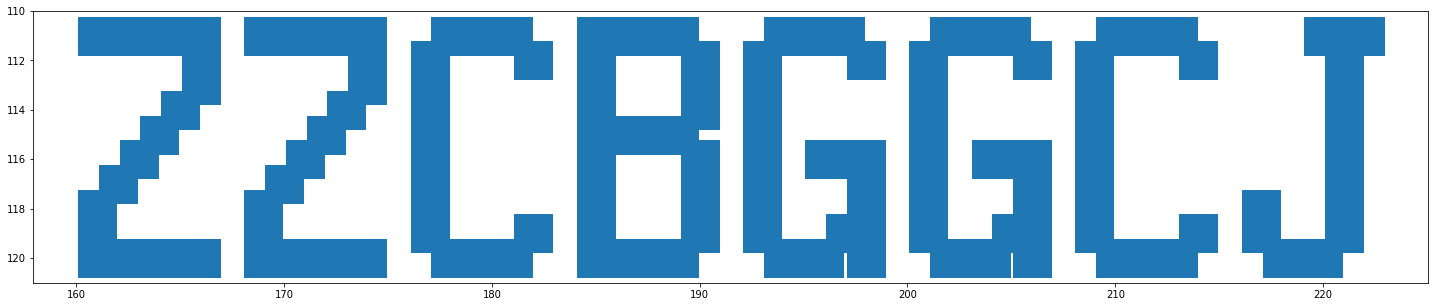

In [21]:
%%time
with open(input_for_day(10), "r") as input_file:
    positions, velocity = np.hsplit(
        np.array([list(map(int, re.findall(r"-?\d+", l))) for l in input_file]), 2
    )


def bbox_area(positions):
    return np.prod(np.max(positions, axis=0) - np.min(positions, axis=0))


last_area = np.iinfo(np.uint64).max
area = bbox_area(positions)
while area < last_area:
    positions += velocity
    last_area = area
    area = bbox_area(positions)

positions -= velocity
plt.figure(figsize=(25, 5))
plt.scatter(*np.hsplit(positions, 2), s=1500, marker="s")
plt.ylim(121, 110)
print("Answer:")

### Part Two
Impressed by your sub-hour communication capabilities, the Elves are curious: exactly how many seconds would they have needed to wait for that message to appear?

In [22]:
%%time
with open(input_for_day(10), "r") as input_file:
    positions, velocity = np.hsplit(
        np.array([list(map(int, re.findall(r"-?\d+", l))) for l in input_file]), 2
    )


def bbox_area(positions):
    return np.prod(np.max(positions, axis=0) - np.min(positions, axis=0))


last_area = np.iinfo(np.uint64).max
area = bbox_area(positions)
counter = -1
while area < last_area:
    counter += 1
    positions += velocity
    last_area = area
    area = bbox_area(positions)

print(f"Answer: {counter}")

Answer: 10886
CPU times: user 466 ms, sys: 0 ns, total: 466 ms
Wall time: 493 ms


## Day 11
### Part One
What is the X,Y coordinate of the top-left fuel cell of the 3x3 square with the largest total power?

In [23]:
%%time
with open(input_for_day(11), "r") as input_file:
    serial = int(input_file.read())


def fuel_level(x, y, serial):
    rack_id = x + 10
    return (((rack_id * y + serial) * rack_id) // 100) % 10 - 5


x, y = np.mgrid[0:300, 0:300]
levels = fuel_level(x, y, serial).reshape((300, 300))

res = convolve2d(levels, np.ones((3, 3)), mode="valid")
x, y = np.unravel_index(np.argmax(res), res.shape)

print(f"Answer: {x},{y}")

Answer: 21,34
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 45.7 ms


### Part Two
What is the X,Y,size identifier of the square with the largest total power?

In [24]:
%%time
with open(input_for_day(11), "r") as input_file:
    serial = int(input_file.read())


def fuel_level(x, y, serial):
    rack_id = x + 10
    return (((rack_id * y + serial) * rack_id) // 100) % 10 - 5


def max_square(levels, size):
    kernel = np.ones((size, 1))
    result = convolve2d(
        convolve2d(levels, kernel, mode="valid"), kernel.T, mode="valid"
    )
    return np.max(result), np.unravel_index(np.argmax(result), result.shape), size


x, y = np.mgrid[0:300, 0:300]
levels = fuel_level(x, y, serial).reshape((300, 300))

_, (x, y), s = max(max_square(levels, s) for s in range(1, 301))

print(f"Answer: {x},{y},{s}")

Answer: 90,244,16
CPU times: user 14.6 s, sys: 0 ns, total: 14.6 s
Wall time: 14.7 s


Really fast version using integral images.

In [25]:
%%time
with open(input_for_day(11), "r") as input_file:
    serial = int(input_file.read())

display_size = 300


def fuel_level(x, y, serial):
    rack_id = x + 10
    return (((rack_id * y + serial) * rack_id) // 100) % 10 - 5


def max_square(integral, size):
    x, y = np.mgrid[size:display_size, size:display_size]
    result = (
        integral[x, y]
        - integral[x, y - size]
        - integral[x - size, y]
        + integral[x - size, y - size]
    )
    max_index = np.unravel_index(np.argmax(result), result.shape)
    return result[max_index], max_index, size


x, y = np.mgrid[0:display_size, 0:display_size]
integral = np.zeros((display_size + 1, display_size + 1), dtype=np.int64)
integral[1:, 1:] = np.cumsum(
    fuel_level(x, y, serial).reshape((display_size, display_size)), axis=0
).cumsum(axis=1)

_, (x, y), s = max(max_square(integral, s) for s in range(1, display_size))

print(f"Answer: {x},{y},{s}")

Answer: 90,244,16
CPU times: user 413 ms, sys: 480 µs, total: 413 ms
Wall time: 460 ms
